In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

plt.style.use('seaborn-v0_8')
%matplotlib inline

In [8]:
stock1 = 'MARUTI.NS'
stock2 = 'TATAMOTORS.NS'
start_date = '2023-01-01'
end_date = '2025-01-01'

df1 = yf.download(stock1, start=start_date, end=end_date)
df2 = yf.download(stock2, start=start_date, end=end_date)

prices = pd.concat([df1['Close'], df2['Close']], axis=1)
prices.columns = [stock1, stock2]
prices.dropna(inplace=True)
print(prices.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

              MARUTI.NS  TATAMOTORS.NS
Date                                  
2023-01-02  8247.060547     392.362549
2023-01-03  8226.893555     391.468079
2023-01-04  8266.199219     383.219360
2023-01-05  8303.787109     384.511322
2023-01-06  8227.187500     379.641571


In [9]:
def cointegration_test(prices):
    johansen_test = coint_johansen(prices, det_order=0, k_ar_diff=1)
    for i in range(len(johansen_test.trace_stat)):
        print(f"Johansen Test {i+1}: Trace = {johansen_test.trace_stat[i]:.2f}, Crit = {johansen_test.cvt[i, 1]:.2f}")
        if johansen_test.trace_stat[i] > johansen_test.cvt[i, 1]:
            print("=> Cointegrated")
        else:
            print("=> Not cointegrated")

cointegration_test(prices)

score, pvalue, _ = coint(prices[stock1], prices[stock2])
print(f"\nEngle-Granger Test p-value: {pvalue:.4f}")
if pvalue < 0.05:
    print("=> Likely cointegrated")
else:
    print("=> Likely not cointegrated")

Johansen Test 1: Trace = 17.18, Crit = 15.49
=> Cointegrated
Johansen Test 2: Trace = 2.70, Crit = 3.84
=> Not cointegrated

Engle-Granger Test p-value: 0.1623
=> Likely not cointegrated


X = sm.add_constant(prices[stock2])
model = sm.OLS(prices[stock1], X).fit()
hedge_ratio = model.params.iloc[1]  # ✅ safer indexing
print(f"Hedge Ratio: {hedge_ratio:.4f}")

In [10]:
spread = prices[stock1] - hedge_ratio * prices[stock2]
spread.name = 'Spread'

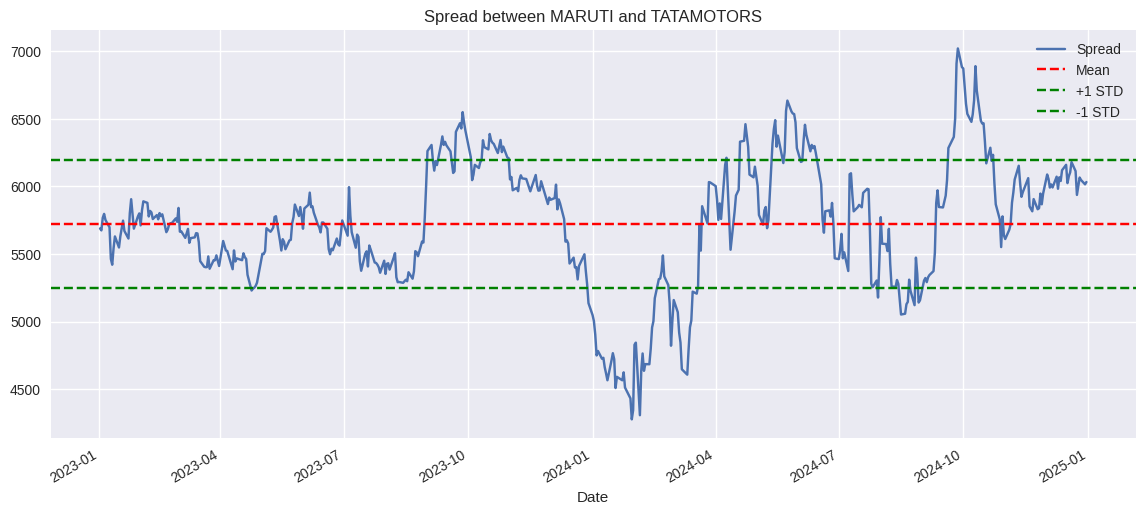

In [11]:
plt.figure(figsize=(14, 6))
spread.plot()
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
plt.axhline(spread.mean() + spread.std(), color='green', linestyle='--', label='+1 STD')
plt.axhline(spread.mean() - spread.std(), color='green', linestyle='--', label='-1 STD')
plt.title("Spread between MARUTI and TATAMOTORS")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def zscore(series):
    return (series - series.mean()) / series.std()

spread_z = zscore(spread)

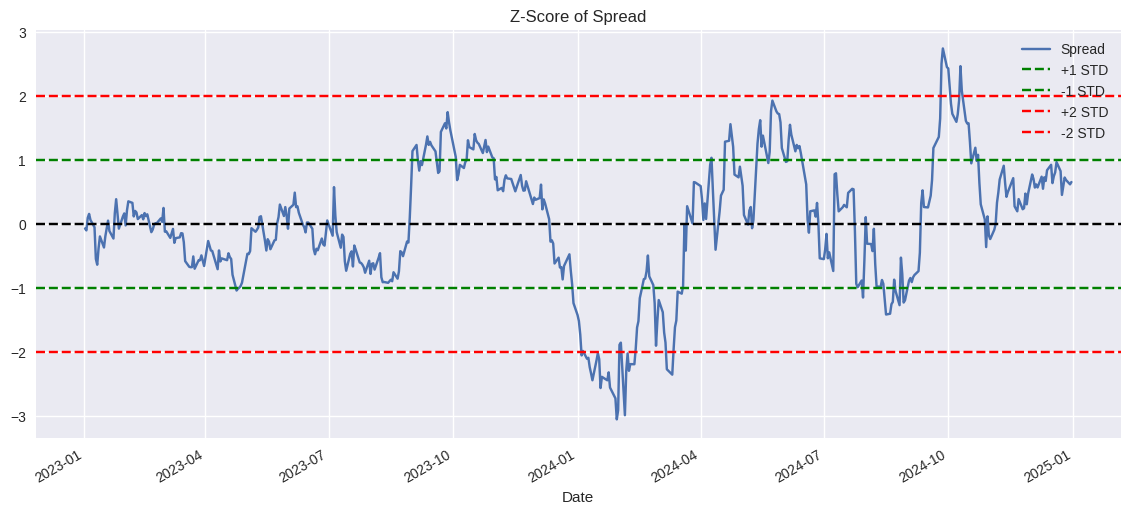

In [13]:
plt.figure(figsize=(14, 6))
spread_z.plot()
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1, color='green', linestyle='--', label='+1 STD')
plt.axhline(-1, color='green', linestyle='--', label='-1 STD')
plt.axhline(2, color='red', linestyle='--', label='+2 STD')
plt.axhline(-2, color='red', linestyle='--', label='-2 STD')
plt.title("Z-Score of Spread")
plt.legend()
plt.grid(True)
plt.show()

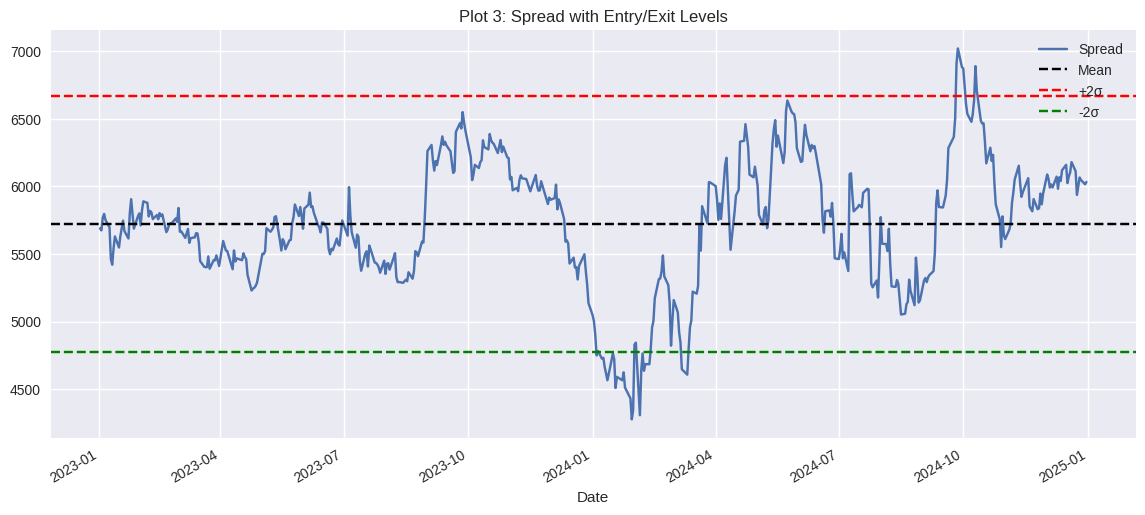

In [14]:
entry = 2
plt.figure(figsize=(14, 6))
spread.plot(label='Spread')
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.axhline(spread.mean() + spread.std() * entry, color='red', linestyle='--', label='+2σ')
plt.axhline(spread.mean() - spread.std() * entry, color='green', linestyle='--', label='-2σ')
plt.title("Plot 3: Spread with Entry/Exit Levels")
plt.legend()
plt.grid(True)
plt.show()

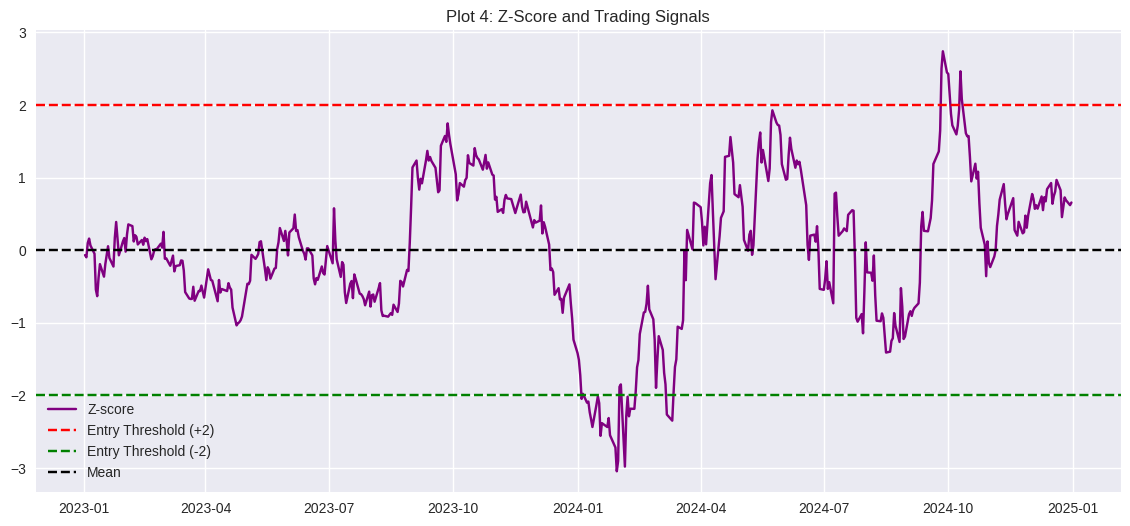

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(spread_z, label='Z-score', color='purple')
plt.axhline(entry, color='red', linestyle='--', label='Entry Threshold (+2)')
plt.axhline(-entry, color='green', linestyle='--', label='Entry Threshold (-2)')
plt.axhline(0, color='black', linestyle='--', label='Mean')
plt.title('Plot 4: Z-Score and Trading Signals')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
exit_threshold = 1

signals = pd.DataFrame(index=spread.index)
signals['Z'] = spread_z
signals['Long'] = spread_z < -entry
signals['Short'] = spread_z > entry
signals['Exit'] = (spread_z > -exit_threshold) & (spread_z < exit_threshold)

print("Long signals:", signals['Long'].sum())
print("Short signals:", signals['Short'].sum())
print("Exit signals:", signals['Exit'].sum())
print(signals.head())

Long signals: 25
Short signals: 6
Exit signals: 356
                   Z   Long  Short  Exit
Date                                    
2023-01-02 -0.067332  False  False  True
2023-01-03 -0.097551  False  False  True
2023-01-04  0.098685  False  False  True
2023-01-05  0.160164  False  False  True
2023-01-06  0.065622  False  False  True


In [17]:
signals['Returns'] = prices[stock1].pct_change()
signals['Strategy Returns'] = 0.0
signals.loc[signals['Long'], 'Strategy Returns'] = signals['Returns']
signals.loc[signals['Short'], 'Strategy Returns'] = -signals['Returns']
signals.loc[signals['Exit'], 'Strategy Returns'] = 0.0
signals['Cumulative Returns'] = (signals['Strategy Returns'] + 1).cumprod()

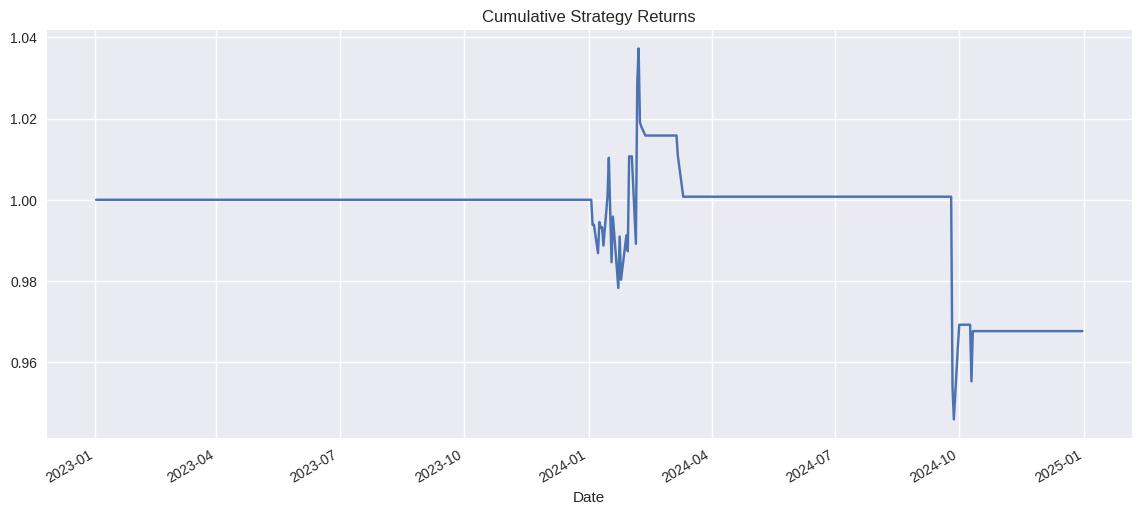

Total Strategy Return: -3.23%


In [18]:
plt.figure(figsize=(14, 6))
signals['Cumulative Returns'].plot()
plt.title("Cumulative Strategy Returns")
plt.grid(True)
plt.show()

print(f"Total Strategy Return: {(signals['Cumulative Returns'].iloc[-1] - 1) * 100:.2f}%")